In [32]:
def extract_cascades_info_subsample(vi,tiledir,tiles,nights,petals,subset_id):
  dataname = tiledir+'/'+tiles[0] + '/zbest-'+str(petals[0])+'-'+str(tiles[0])+'-subset-'+str(subset_id)+'.fits'
  
  line_information = Table.read('/global/homes/r/raichoor/sv1/sv1-elg-cascades-allspec-vi.fits')
  print(dataname)
  line_info_qq = line_information[line_information['FN']==dataname]
  print(len(line_info_qq))
    #tf = Table.read(dataname,hdu='FIBERMAP')
  tspec = Table.read(dataname,hdu='ZBEST')
  for i in range(1,len(petals)):
      #tfn = Table.read(tiledir+'/'+tiles[0] + '/deep/zbest-'+str(petals[i])+'-'+str(tiles[0])+'-deep.fits',hdu='FIBERMAP')
      #tf = vstack([tf,tfn])
      line_info_qq2 = line_information[line_information['FN']==tiledir+'/'+tiles[0] + '/zbest-'+str(petals[i])+'-'+str(tiles[0])+'-subset-'+str(subset_id)+'.fits']
      tspecn = Table.read(tiledir+'/'+tiles[0] + '/zbest-'+str(petals[i])+'-'+str(tiles[0])+'-subset-'+str(subset_id)+'.fits',hdu='ZBEST')
      tspec = vstack([tspec,tspecn])
      line_info_qq = vstack([line_info_qq,line_info_qq2])
      print(len(line_info_qq))
  #EXPID = list(set(tf['EXPID']))[-1] 
  #'''This was 0 before but  '''
  #tf = tf[tf['EXPID']==EXPID]
  #tf_df = tf['TARGETID','TARGET_RA','TARGET_DEC','FIBER','FLUX_G','FLUX_R','FLUX_Z','FIBERFLUX_G','FIBERFLUX_R','FIBERFLUX_Z','EBV'].to_pandas()
  #tf_df = tf.to_pandas()
  tspec_df = tspec['TARGETID','DELTACHI2','Z','ZWARN','ZERR','CHI2','NPIXELS','SPECTYPE'].to_pandas()
  line_info_qq_df = line_info_qq['TARGETID','DELTACHI2','FOII','FOII_ERR'].to_pandas()
  vi = vi.merge(tspec_df, how='left', on='TARGETID',suffixes=('', '_cas'))
  vi = vi.merge(line_info_qq_df,how='left',on='TARGETID',suffixes=('','_anand'))  
  #print(len(vi.columns))
  return vi

In [8]:
def return_truth_table_name(type_name, tileid):
    truth_table_filename = {'ELG':{'80608':'desi-vi_ELG_tile80608_nightdeep_merged_all_210208.csv','80606':'desi-vi_ELG_tile80606_nightdeep_merged_all_210218.csv'},
                           'LRG':{'80605':'desi-vi_LRG_tile80605_nightdeep_merged_all_210224.csv','80609':'desi-vi_LRG_tile80609_nightdeep_merged_all_21030.csv'},
                           'BGS':{'80613':'desi-vi_BGS_tile80613_nightdeep_merged_all_210202.csv'},
                           'QSO':{'80605':'desi-vi_QSO_tile80605_nightdeep_merged_all_210223_ADDING_object_info.csv','80607':'desi-vi_QSO_tile80607_nightdeep_merged_all_210214_ADDING_object_info.csv',
                                 '80609':'desi-vi_QSO_tile80609_nightdeep_merged_all_210210_ADDING_object_info.csv'}}
    VI_dir ='/global/cfs/cdirs/desi/sv/vi/TruthTables/Blanc/'+type_name+'/'
    return VI_dir+truth_table_filename[type_name][tileid]

In [9]:
def return_blanc_and_cascades_info(type_name,tileid,tiledir,subset_id):
    
    #tiledir   = '/global/cfs/cdirs/desi/spectro/redux/cascades/tiles/'
    file_name = return_truth_table_name(type_name,tileid)
    vi_old = pd.read_csv(file_name, delimiter = ",", engine='python', keep_default_na=False)
    #print(len(vi_old))
    nights = ['20201223']
    petals = ['0','1','2','3','4', '5', '6' ,'7', '8', '9']
    
    vi = extract_cascades_info_subsample(vi_old,tiledir,[tileid],nights,petals,subset_id)  
    
    vi['delta_delta']=vi['DELTACHI2']-vi['DELTACHI2_cas']
    vi['dz']=abs(vi['Redrock_z']-vi['best_z'])/(1.+vi['best_z'])
    vi['dz_cas']=abs(vi['Z']-vi['best_z'])/(1.+vi['best_z'])
    vi['subset_id']=subset_id
    return vi    

In [10]:
import pandas as pd
import os, sys, glob
import fnmatch
import matplotlib.pyplot as plt
import re
import numpy as np
from astropy.table import Table, join, vstack
import astropy.io.fits as pf
import pandas as pd
plt.rcParams['figure.figsize'] = [12, 8]

In [40]:
type_name_list = ['ELG','ELG','LRG','LRG','BGS','QSO','QSO','QSO']
tileid_list = ['80606','80608','80605','80609','80613','80605','80607','80609']
type_name_list = ['ELG','ELG']
tileid_list = ['80606','80608']
for i in range(0,len(type_name_list)):
    if (tileid_list[i]=='80606') | (tileid_list[i]=='80605'):
        dir_depth = '/global/cfs/cdirs/desi/users/rongpu/redux/cascades/3x_depth'
    else:
        dir_depth = '/global/cfs/cdirs/desi/users/rongpu/redux/cascades/4x_depth'
    data1 = return_blanc_and_cascades_info(type_name_list[i],tileid_list[i],dir_depth,'1')
    data2 = return_blanc_and_cascades_info(type_name_list[i],tileid_list[i],dir_depth,'2')
    #sub_catalog = line_information[line_information['FN']==]
    #data3 = return_blanc_and_cascades_info(type_name_list[i],tileid_list[i],dir_depth,'3')
    #data4 = return_blanc_and_cascades_info(type_name_list[i],tileid_list[i],dir_depth,'4')

    total_data = data1.append(data2)
    #total_data = total_data.append(data3)
    #total_data = total_data.append(data4)
    total_data.to_csv(type_name_list[i]+'_'+tileid_list[i]+'_Cascades_subsamples_OII.csv',index=False)
    
    #total_merge = data1.merge(data2, how='left', on='TARGETID',suffixes=('_1', '_2'))

/global/cfs/cdirs/desi/users/rongpu/redux/cascades/3x_depth/80606/zbest-0-80606-subset-1.fits
412
821
1226
1624
2025
2431
2830
3237
3647
4060
/global/cfs/cdirs/desi/users/rongpu/redux/cascades/3x_depth/80606/zbest-0-80606-subset-2.fits
412
821
1226
1624
2025
2431
2830
3237
3647
4060
/global/cfs/cdirs/desi/users/rongpu/redux/cascades/4x_depth/80608/zbest-0-80608-subset-1.fits
403
801
1210
1616
2022
2436
2839
3247
3662
4070
/global/cfs/cdirs/desi/users/rongpu/redux/cascades/4x_depth/80608/zbest-0-80608-subset-2.fits
403
801
1210
1616
2022
2436
2839
3247
3662
4070


(0.0, 10000.0)

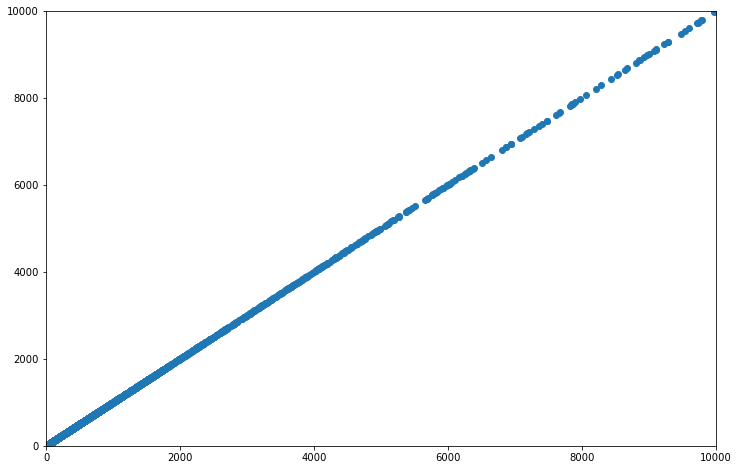

In [39]:
plt.scatter(total_data['DELTACHI2_cas'],total_data['DELTACHI2_anand'])
#plt.xlim(0,10000)
#plt.ylim(0,10000)

In [38]:
line_information = Table.read('/global/homes/r/raichoor/sv1/sv1-elg-cascades-allspec-vi.fits')

In [17]:
line_information[line_information['FN']=='/global/cfs/cdirs/desi/users/rongpu/redux/cascades/3x_depth/80605/zbest-0-80605-subset-1.fits'

SyntaxError: unexpected EOF while parsing (<ipython-input-17-1d28e3aee054>, line 1)

In [21]:
line_information.columns

<TableColumns names=('TARGETID','CHI2','Z','ZERR','ZWARN','NPIXELS','SPECTYPE','SUBTYPE','NCOEFF','DELTACHI2','PETAL_LOC','DEVICE_LOC','LOCATION','FIBER','FIBERSTATUS','TARGET_RA','TARGET_DEC','LAMBDA_REF','FA_TARGET','FA_TYPE','OBJTYPE','FIBERASSIGN_X','FIBERASSIGN_Y','PRIORITY','SUBPRIORITY','OBSCONDITIONS','MORPHTYPE','FLUX_G','FLUX_R','FLUX_Z','FLUX_IVAR_G','FLUX_IVAR_R','FLUX_IVAR_Z','EBV','FLUX_W1','FLUX_W2','FIBERFLUX_G','FIBERFLUX_R','FIBERFLUX_Z','FIBERTOTFLUX_G','FIBERTOTFLUX_R','FIBERTOTFLUX_Z','MASKBITS','SERSIC','SHAPE_R','SHAPE_E1','SHAPE_E2','PHOTSYS','SV1_DESI_TARGET','SV1_BGS_TARGET','SV1_MWS_TARGET','PRIORITY_INIT','NUMOBS_INIT','RELEASE','BRICKNAME','BRICK_OBJID','DESI_TARGET','BGS_TARGET','MWS_TARGET','FIBER_X','FIBER_Y','FIBER_RA','FIBER_DEC','TILEID','FN','HASCOADD','WEIGHT','FOII','FOII_ERR','TARGETS','NEXP','EXPIDS','NIGHTS','EXPTIME','B_DEPTH','R_DEPTH','Z_DEPTH','B_DEPTH_EBVAIR','R_DEPTH_EBVAIR','Z_DEPTH_EBVAIR','GTOT','GFIB','GR','RZ','BLUE','RED','FDRBOX','L